Most of the stuff here is focused on comparing the output a preliminary time slicing algorithm with merged and unmerged hits. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections

In [2]:
#We can pull in our merged and unmerged hit data. The neutrino vertices array is common to both files.
data_unmerged = np.load('../hitwise_detector_sim_0002459.npz')
data_merged = np.load('python/test_0002459_merged.npz')
neutrino_vertices = data_unmerged['first']
hit_array_unmerged = data_unmerged['second']
hit_array_merged = data_merged['first']
print(np.shape(hit_array_unmerged))
print(np.shape(hit_array_merged))

(252256, 8)
(107479, 8)


In [3]:
#Some useful sorting functions
def SortByTime(array):
    sorted_array = array[np.argsort(array[:,5])]
    return(sorted_array)

def SortByNN(array):
    sorted_array = array[np.argsort(array[:,0])]
    return(sorted_array)

In [4]:
sorted_hits_merged = SortByTime(hit_array_merged)
sorted_hits_unmerged = SortByTime(hit_array_unmerged)

In [5]:
#A useful data structure that can serve as a test of energy efficiency

#Creates this array using unmerged PEs
neutrino_PE_array_unmerged = np.zeros((5979, 2))
for i in range(5979):
    PEs = 0.
    sub_array = sorted_hits_unmerged[sorted_hits_unmerged[:, 0] == i]
    if np.shape(sub_array)[0] > 0:
        for hit in sub_array:
            PEs += hit[6]
    neutrino_PE_array_unmerged[i][0] = i
    neutrino_PE_array_unmerged[i][1] = PEs

print(neutrino_PE_array_unmerged)

#Creates this array using unmerged PEs
neutrino_PE_array_merged = np.zeros((5979, 2))
for i in range(5979):
    PEs = 0.
    sub_array = sorted_hits_merged[sorted_hits_merged[:, 0] == i]
    if np.shape(sub_array)[0] > 0:
        for hit in sub_array:
            PEs += hit[6]
    neutrino_PE_array_merged[i][0] = i
    neutrino_PE_array_merged[i][1] = PEs

print(neutrino_PE_array_merged)




[[0.00000000e+00 7.34770243e+01]
 [1.00000000e+00 0.00000000e+00]
 [2.00000000e+00 1.28117544e+03]
 ...
 [5.97600000e+03 0.00000000e+00]
 [5.97700000e+03 3.66649168e+03]
 [5.97800000e+03 0.00000000e+00]]
[[0.00000000e+00 7.34770243e+01]
 [1.00000000e+00 0.00000000e+00]
 [2.00000000e+00 1.28117544e+03]
 ...
 [5.97600000e+03 0.00000000e+00]
 [5.97700000e+03 3.66649168e+03]
 [5.97800000e+03 0.00000000e+00]]


In [6]:
#As a quick check, the sum of PEs for these should be the same - good they are!
print(np.sum(neutrino_PE_array_merged[:,1]))
print(np.sum(neutrino_PE_array_unmerged[:,1]))

4580167.087710667
4580167.087710667


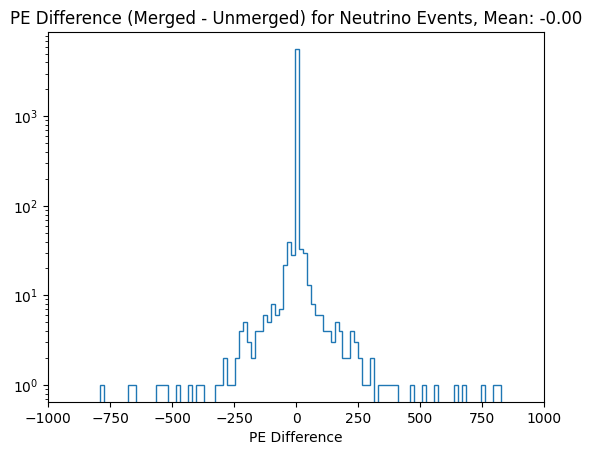

In [32]:
PE_differences = [] #merged - unmerged
for i in range(5979): 
    merged_PE = neutrino_PE_array_merged[i][1]
    unmerged_PE = neutrino_PE_array_unmerged[i][1]
    diff = merged_PE - unmerged_PE
    PE_differences.append(diff)
avg = np.average(PE_differences)
plt.hist(PE_differences, bins = 200, histtype = 'step')
plt.yscale('log')
plt.xlim((-1000,1000))
plt.title(f'PE Difference (Merged - Unmerged) for Neutrino Events, Mean: {avg:.2f}')
plt.xlabel("PE Difference")
plt.show()

In [ ]:
#A time slicer based on the principles of the dune-tms slicer. takes thresholds and a hits array.
#This function will return a list of lists of arrays. lol
def SimpleTimeSlicer(hits, initial_threshold_energy = 50, drop_threshold_energy = 40):
    sorted_hits = SortByTime(hits)
    events = [] #This object stores the final "events" or slices that are grouped by the algorithm
    window_duration_ns = 19
    
    current_window_hits = collections.deque() 
    current_window_energy_sum = 0.0

    in_accumulation_phase = False
    current_event_hits = [] #stores hit info for our event that is accumulating

    for hit_row in sorted_hits: # Iterate through each full hit row
        hit_time = hit_row[5]   # Time is at index 5
        hit_energy = hit_row[6] # Energy is at index 6

        #Add the current full hit row to the window
        current_window_hits.append(hit_row) # Store the entire row
        current_window_energy_sum += hit_energy #add the hit energy to our current window

        #Remove hits that are outside the current window, basically sliding the deque forward
        #The window is defined by (current_hit_time - window_duration_ns, current_hit_time]
        while current_window_hits and current_window_hits[0][5] <= hit_time - window_duration_ns:
            oldest_hit_row = current_window_hits.popleft() # Get the full oldest row
            oldest_hit_energy = oldest_hit_row[6] # Access energy from the row
            current_window_energy_sum -= oldest_hit_energy

        #Handle accumulation logic
        if not in_accumulation_phase:
            #Not in accumulation, if we pass the threshold we should start
            if current_window_energy_sum >= initial_threshold_energy:
                    in_accumulation_phase = True #here we activate accumulation mode - begin a slice.
                    # When we *start* accumulation, initialize `current_event_hits` with
                    # all hits currently within the *valid* window (i.e., those in `current_window_hits`).
                    # We need to make a copy here (`list(...)`) because `current_window_hits`
                    # will continue to change as the window slides.
                    #this making a copy rather than grabbing it everytime the hit slides was the reason we encountered duplicates in previous versions
                    current_event_hits = list(current_window_hits)
        else: # We ARE currently in an accumulation phase
            # Add the current full hit row to the accumulating event.
            current_event_hits.append(hit_row)

            # Check if the energy in the *current window* has dropped below the threshold, after adding the most recent entry
            if current_window_energy_sum < drop_threshold_energy:
                # If indeed we have dropped below threshold go ahead and 
                events.append(current_event_hits)
                in_accumulation_phase = False #turning off the 
                current_event_hits = [] # Reset for the next event - dumping the current events hit list

    # After iterating through all hits, check if we were still in an accumulation phase.
    # If so, the last event needs to be saved, it won't do this automatically!
    if in_accumulation_phase:
        events.append(current_event_hits)
    
    return(events)


In [ ]:
#Some other utility functions

#this function checks how many total events were placed into groups. 
def ValidateEvents(events):
    iter = 0
    for group in events:
        for hit in group:
            iter += 1
    return(iter)

#this function will return a list of hits grouped into arrays based on their event. May incorporate into main function...
#then individual slices can be accessed by their index. 
def StackEvents(events):
    event_list = []
    for i in range(len(events)):
        event_list.append(np.vstack(events[i]))
    return(event_list)
            
#This function can print out the time slices
def SlicerPrinting(events, loud = False):
    print(f"Detected {len(events)} events:")
    for i, event in enumerate(events):
        print(f"\n--- Event {i+1} ---")
        total_energy_event = sum(hit_row[6] for hit_row in event) # Sum energy from full rows
        print(f"Total hits: {len(event)}")
        print(f"Total energy: {total_energy_event:.2f}")
        # Get min/max time from the full hit rows in the event
        if event: # Ensure event is not empty before accessing elements
            start_time = min(hit_row[5] for hit_row in event)
            end_time = max(hit_row[5] for hit_row in event)
            print(f"Time range: {start_time:.1f} ns - {end_time:.1f} ns")
            
        if loud:
            print("Hits (full data) in event:")
            for hit_row in event:
                # Print specific fields for clarity, or the whole row
                print(f"  Neutrino: {hit_row[0]}, Hit: {hit_row[1]}, Time: {hit_row[5]:.1f}, Energy: {hit_row[6]:.1f}, X: {hit_row[2]}")

In [ ]:
sliced = SimpleTimeSlicer(hit_array)
print(ValidateEvents(sliced))
#SlicerPrinting(sliced)

In [ ]:
slice_stack = StackEvents(sliced)

In [ ]:
#Lets add a function to check the efficiency of our slicing. (sorta modeled off our previous) THIS IS JUST A TEMPLATE
group_no = 23
events_represented = np.unique(groups[group_number][:, 0])
for neutrino_number in events_represented:
    total_PE_share = 0.
    for hit in groups[group_no][:, :]:
        if hit[0] == neutrino_number:
            total_PE_share += hit[6]
            
    total_event_PE = neutrino_total_PE_array[int(neutrino_number)][1]
    percent_PE_here = (total_PE_share / total_event_PE) * 100
    print(f"For neutrino number {neutrino_number}, group {group_no} contains {percent_PE_here}% of event PE")